# evaluate ekman pumping in easterlies experiment .. as a function of outcropping density class

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:37303 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 100.00 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [5]:
ee = explore.ExperimentExplorer(session=master_session, experiment='01deg_jra55v13_ryf9091')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [6]:
#import cartopy.feature as cft
#land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
#                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [7]:
expt = '01deg_jra55v13_ryf9091'
variable='geolat_c'
geolat_c = cc.querying.getvar(expt,variable,master_session, n=-1)
geolat_c.load()
print(geolat_c.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

(2700, 3600)
(2700, 3600)


In [8]:
#Calculate coriolis param

# these are the values used by MOM5
Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m

f = 2 * Ω * np.sin(np.deg2rad(geolat_c)) # convert lat in radians
f = f.rename('Coriolis')
f.attrs['long_name'] = 'Coriolis parameter'
f.attrs['units'] = 's-1'
f.attrs['coordinates'] = 'geolon_c geolat_c'
print(f.shape)

(2700, 3600)


In [32]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt='01deg_jra55v13_ryf9091_easterlies_up10_meridional'
ekfi='ek_upm_tmp_'

In [33]:
# 15years of simulation:
start_time='2150-01-01'
end_time='2164-12-31'
#end_time='2150-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-60)#-50.04)

##### NOTE: I was having memory troubles running this all in one go, so I've split into two sections. 
# The script needs to be run twice for the two longitude ranges, and each time change the name of the file it is saved to.

region = 'east'
#region = 'west'
if region == 'west':
    # Just cover Mertz and Ross, save as west:
    lon_slice  = slice(-280, -100)
elif region == 'east':
    # Just cover Weddell and Prydz, save as east:
    lon_slice  = slice(-100, 80)
    
#do global
lon_slice  = slice(-280, 80)

In [34]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

# check isopycnal binning

In [35]:
# Surface density:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).sel(st_ocean=0,method='nearest') #.resample({'time':'Y'}).mean('time')


Exception during reset or similar
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 697, in _finalize_fairy
    fairy._reset(pool)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/pool/base.py", line 893, in _reset
    pool._dialect.do_rollback(self)
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/engine/default.py", line 558, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 23377370965824 and this is thread id 23374713882368.
Exception closing connection <sqlite3.Connection object at 0x15425b985120>
Traceback (most recent call last):
  File "/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/sqlalchemy/po

In [36]:
isopycnal_bins = np.arange(24., 29.1, 0.1)
isopycnal_bins

array([24. , 24.1, 24.2, 24.3, 24.4, 24.5, 24.6, 24.7, 24.8, 24.9, 25. ,
       25.1, 25.2, 25.3, 25.4, 25.5, 25.6, 25.7, 25.8, 25.9, 26. , 26.1,
       26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27. , 27.1, 27.2,
       27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9, 28. , 28.1, 28.2, 28.3,
       28.4, 28.5, 28.6, 28.7, 28.8, 28.9, 29. , 29.1])

In [37]:
pot_rho_0

,Array,Chunk
Bytes,565.25 MiB,94.92 kiB
Shape,"(84, 490, 3600)","(1, 135, 180)"
Count,436828 Tasks,6720 Chunks
Type,float32,numpy.ndarray


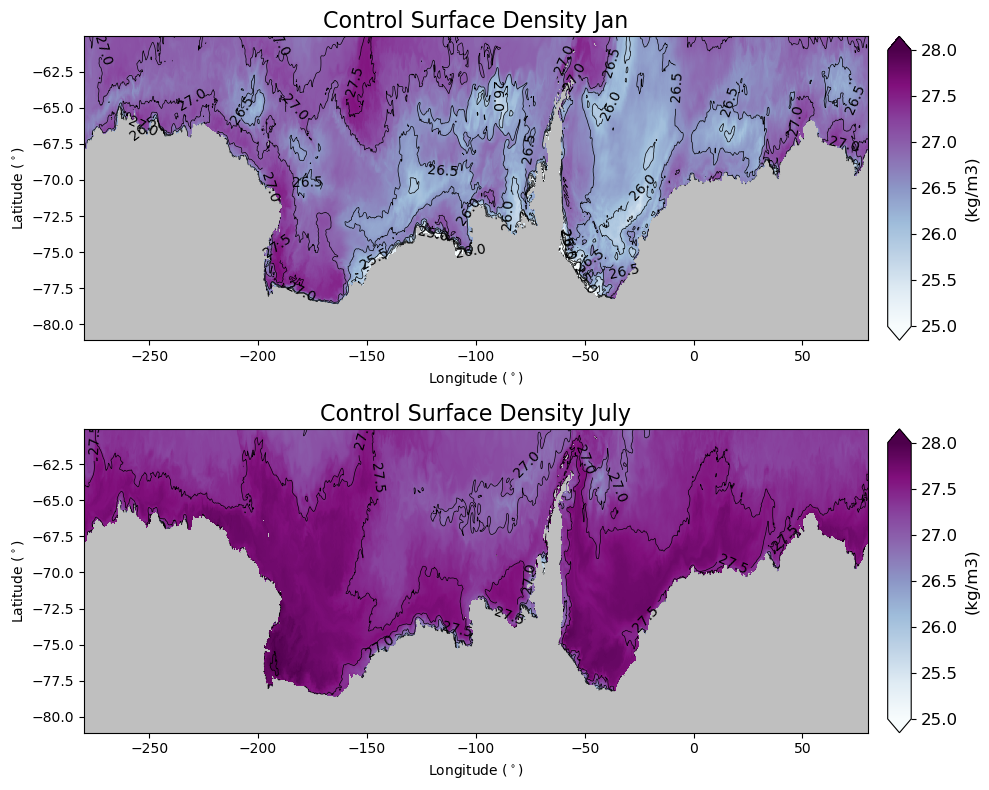

In [38]:
levels=np.arange(24., 29., 0.5)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.gca().patch.set_color('.75')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
p1=plt.pcolormesh(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[0],cmap=plt.cm.BuPu,vmin=25,vmax=28)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[0],levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
#plt.ylim([-66,-62])
#plt.xlim([-265,-255])
plt.title('Control Surface Density Jan',fontsize = 16)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'(kg/m3)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(2,1,2)
plt.gca().patch.set_color('.75')
#p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
p1=plt.pcolormesh(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[6],cmap=plt.cm.BuPu,vmin=25,vmax=28)
pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0[6],levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
#plt.ylim([-66,-62])
#plt.xlim([-265,-255])
plt.title('Control Surface Density July',fontsize = 16)

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
cbar.set_label(r'(kg/m3)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()


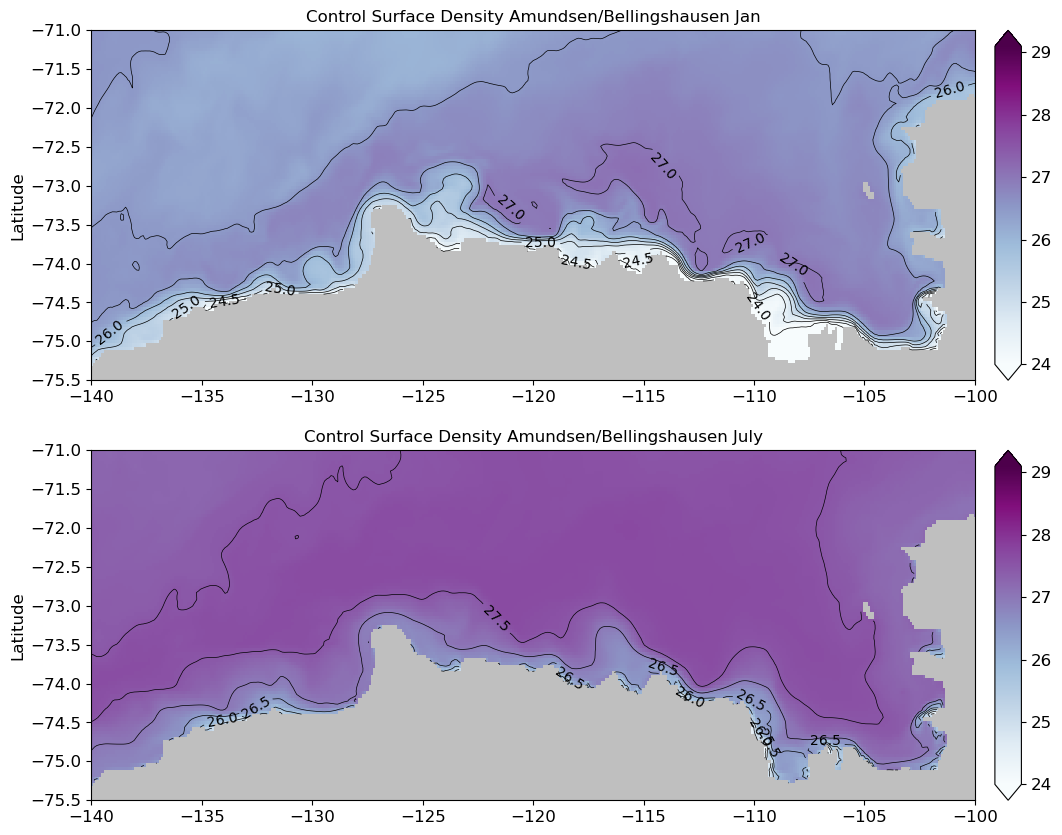

In [39]:
fontsize=12
levels=np.arange(24., 29., 0.5)


plt.figure(figsize=(12,10))

#needed for contour labels
var=pot_rho_0[0].sel(xt_ocean=slice(-150,-90))

plt.subplot(2,1,1)
plt.title('Control Surface Density Amundsen/Bellingshausen Jan',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
p1=plt.pcolormesh(var.xt_ocean,var.yt_ocean,var,vmin=isopycnal_bins[0],vmax=isopycnal_bins[-1],cmap=plt.cm.BuPu)
pr=plt.contour(var.xt_ocean,var.yt_ocean,var,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

var=pot_rho_0[6].sel(xt_ocean=slice(-150,-90))

plt.subplot(2,1,2)
plt.title('Control Surface Density Amundsen/Bellingshausen July',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
p1=plt.pcolormesh(var.xt_ocean,var.yt_ocean,var,vmin=isopycnal_bins[0],vmax=isopycnal_bins[-1],cmap=plt.cm.BuPu)
pr=plt.contour(var.xt_ocean,var.yt_ocean,var,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [40]:
ht=ht.sel(xt_ocean=lon_slice)
pot_rho_0=pot_rho_0.sel(xt_ocean=lon_slice)
pot_rho_0

,Array,Chunk
Bytes,565.25 MiB,94.92 kiB
Shape,"(84, 490, 3600)","(1, 135, 180)"
Count,436828 Tasks,6720 Chunks
Type,float32,numpy.ndarray


## calculate static differentials

In [41]:
#Ekman pumping calc ... method 2
#https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#https://github.com/adele157/easterlies-collaborative-project/blob/master/notebooks/Ekman_pumping/Ekman_pumping_zoomed_Adele.ipynb

# Need to use these unmasked dxu and dyu, because otherwise it spreads the mask and we miss the Ekman pumping in the first ocean cell.

tau_x_con_full = cc.querying.getvar(expt, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
dyu = cc.querying.getvar(expt, 'dyu', master_session, n=1)

In [42]:
dyu['ni'] = tau_x_con_full['xu_ocean'].values
dyu['nj'] = tau_x_con_full['yu_ocean'].values
dyu = dyu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dyu = dyu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

In [43]:
dxu = cc.querying.getvar(expt, 'dxu', master_session, n=1)
dxu['ni'] = tau_x_con_full['xu_ocean'].values
dxu['nj'] = tau_x_con_full['yu_ocean'].values
dxu = dxu.rename(({'ni':'xu_ocean', 'nj':'yu_ocean'}))
dxu = dxu.sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice)

In [44]:
dxu

<xarray.DataArray 'dxu' (yu_ocean: 490, xu_ocean: 3600)>
dask.array<getitem, shape=(490, 3600), dtype=float32, chunksize=(490, 900), chunktype=numpy.ndarray>
Coordinates:
    TLON      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    TLAT      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    ULON      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
    ULAT      (yu_ocean, xu_ocean) float32 dask.array<chunksize=(490, 900), meta=np.ndarray>
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 ... -60.12 -60.07 -60.02
Attributes:
    long_name:  U cell width through middle
    units:      m

In [45]:
# See https://cosima-recipes.readthedocs.io/en/latest/documented_examples/RelativeVorticity.html#gallery-documented-examples-relativevorticity-ipynb
#ds = xr.open_mfdataset('/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output000/ocean/ocean_grid.nc', combine='by_coords')
#inverse_dxtn = 0.5*(1/ds.dxu + np.roll(1/ds.dxu, 1, axis=1))
#inverse_dyte = 0.5*(1/ds.dyu + np.roll(1/ds.dyu, 1, axis=1))

# use dyu from above, because otherwise the nans from land spread:
inverse_dyte = 0.5*(1/dyu + np.roll(1/dyu, 1, axis=0))
inverse_dxtn = 0.5*(1/dxu + np.roll(1/dxu, 1, axis=0))

## Curl Calculations

In [46]:
tau_x = cc.querying.getvar(expt, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_x = tau_x.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice) #.resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_x = tau_x.load()

tau_y = cc.querying.getvar(expt, 'tau_y', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
tau_y = tau_y.sel(time=slice(start_time,end_time)).sel(yu_ocean=lat_slice).sel(xu_ocean=lon_slice) #.resample({'time':'Y'}).mean('time').sel(yu_ocean=lat_slice)
tau_y = tau_y.load()

In [47]:
time_monthly = tau_x.time.values

# Construct an xarray of days per month:
n_days_array = cc.querying.getvar(expt,'time_bounds',master_session,
                 start_time=start_time, end_time=end_time,ncfile='ocean.nc')
n_days_array = n_days_array.sel(time=slice(start_time,end_time))
n_days_array = (n_days_array.isel(nv=1) - n_days_array.isel(nv=0))/60/60/24/1e9
n_days_array = n_days_array.astype('int64')

# Create an array with years:
time_yearly = np.arange(int(start_time[0:4]), int(start_time[0:4])+len(tau_x.time)/12, 1).astype('int')
n_years = len(time_yearly)
n_days_array.values

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

In [48]:
# fill land with zeros:
tauy_f = tau_y/f
tauy_f = tauy_f.fillna(0)
taux_f = tau_x/f
taux_f = taux_f.fillna(0)

# compute derivatives:
d_dx_tauyf = (tauy_f - np.roll(tauy_f, 1, axis=2))*inverse_dxtn
d_dy_tauxf = (taux_f - np.roll(taux_f, 1, axis=1))*inverse_dyte

# interpolate onto the same grid:
d_dx_tauyf = 0.5 * (d_dx_tauyf + np.roll(d_dx_tauyf, 1, axis=1))
d_dy_tauxf = 0.5 * (d_dy_tauxf + np.roll(d_dy_tauxf, 1, axis=2))

# compute curl:
curl_tauf = d_dx_tauyf - d_dy_tauxf
curl_tauf = curl_tauf.load()

#convert from m/s to m/day
s_day=60*60*24
rho0 = 1035.

In [49]:
ekman = curl_tauf/rho0*s_day*n_days_array
# mask land:
ekman = ekman.where(ekman!=0)

In [50]:
n_days_array.values

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31,
       30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31,
       30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31,
       30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31,
       30, 31, 30, 31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

In [51]:
# Change coords to t grid:
ekman['xu_ocean'] = ht['xt_ocean'].values
ekman['yu_ocean'] = ht['yt_ocean'].values
ekman = ekman.rename(({'xu_ocean':'xt_ocean', 'yu_ocean':'yt_ocean'}))

In [52]:
ekman
#sum(n_days_array.values)/365
#180/12

<xarray.DataArray (time: 84, yt_ocean: 490, xt_ocean: 3600)>
dask.array<where, shape=(84, 490, 3600), dtype=float64, chunksize=(1, 490, 3600), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * time      (time) object 2150-01-16 12:00:00 ... 2156-12-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    geolon_c  (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    geolat_c  (yt_ocean, xt_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02
    TLON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.75 79.85 79.95
    TLAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -60.05 -60.05 -60.05
    ULON      (yt_ocean, xt_ocean) float32 nan nan nan nan ... 79.8 79.9 80.0
    ULAT      (yt_ocean, xt_ocean) float32 nan nan nan ... -60.02 -60.02 -60.02

In [53]:
#this hangs for some reason, but file looks complete
ds = xr.Dataset({'ekman': ekman})
outpath = ekfi+time_period+'.nc'
ds.to_netcdf(outpath)

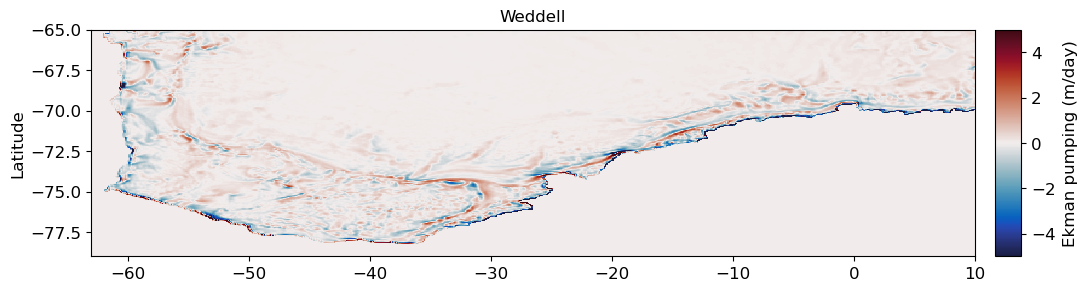

In [54]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(3,1,1)
pc=plt.pcolormesh(ekman.xt_ocean,ekman.yt_ocean,ekman.sum(dim='time')/sum(n_days_array),cmap=cmocean.balance,vmin=-5,vmax=5)
if region == 'west':
    plt.title('Amundsen/Bellingshausen',fontsize=fontsize)
    plt.ylim(-75.5,-71)
    plt.xlim(-140,-100)
elif region == 'east':
    plt.title('Weddell',fontsize=fontsize)
    plt.ylim([-79,-65])
    plt.xlim([-63,10])

#pr=plt.contour(pot_rho_0.xt_ocean,pot_rho_0.yt_ocean,pot_rho_0.mean(dim='time'),levels=isopycnal_bins,colors='k',linewidths=0.5)
#plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')


# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


## if doing more than one year ... use *part2 notebook, otherwise it takes way too long.

In [55]:
# Density binning sigma0:

# Alter if density range doesn't capture surface processes in your study region, or if a different density field (not sigma1) is used
# sigma1:
#isopycnal_bins = np.arange(32.25, 32.75, 0.01) 
# sigma0:
#isopycnal_bins = np.arange(27.5, 28.1, 0.04)

bin_bottoms = isopycnal_bins[:-1]

binned_ekman = xr.DataArray(np.zeros((len(bin_bottoms), n_years, len(ekman.yt_ocean), len(ekman.xt_ocean))), coords = [bin_bottoms, time_yearly, ekman.yt_ocean, ekman.xt_ocean], dims = ['isopycnal_bins', 'year', 'yt_ocean', 'xt_ocean'], name = 'Ekman pumping in isopycnal bins summed over time')
binned_ekman.chunk({'isopycnal_bins':1})

for tt in range(n_years):
    start_t = str(time_yearly[tt]) + '-01-01'
    end_t   = str(time_yearly[tt]) + '-12-31'
    
    ek_tmp = ekman.sel(time=slice(start_t, end_t))
    pot_rho_0_tmp = pot_rho_0.sel(time=slice(start_t, end_t))

    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_0_tmp.where(pot_rho_0_tmp <= isopycnal_bins[i+1]).where(pot_rho_0_tmp > isopycnal_bins[i]) * 0 + 1
        masked_ekman = (ek_tmp * bin_mask).sum(dim = 'time') 
        masked_ekman = masked_ekman.where(masked_ekman != 0) 
        masked_ekman = masked_ekman.load()
        binned_ekman[i,tt,:,:] = masked_ekman
        
    print('Year %i done'%time_yearly[tt])

KeyboardInterrupt: 

In [ ]:
# calculate Ekman sigma0:
isopycnal_bin_diff  = np.diff(isopycnal_bins)
isopycnal_bin_mid   = (isopycnal_bins[1:] + isopycnal_bins[:-1])/2

# Will be overwritten in loop, this is just to get the dimensions etc
ekman_sigma0 = binned_ekman

ekman_tmp = binned_ekman / 365. #for n_days_array

# This procedure defines fluxes from lighter to denser classes as negative, we want the opposite
ekman_sigma0 = -1*ekman_tmp/isopycnal_bin_diff[:,np.newaxis,np.newaxis,np.newaxis]

# Convert the binned (and summed through time) salt and heat transformation DataArrays to Datasets (to save metadata) and save to netCDF
#ds = xr.Dataset({'binned_salt_transformation': salt_transformation})
#ds = xr.Dataset({'binned_heat_transformation': heat_transformation})

#############################################################
ekman_control = ekman_sigma0 
#############################################################

# Rename the isopycnal bin (bottom edge) coord with the isopycnal bin midpoints...
ekman_control.coords['isopycnal_bins'] = isopycnal_bin_mid
ds = xr.Dataset({'ekman_control': ekman_control})
outpath = 'ekmanpump_sigma0_'+region+time_period+'.nc'
ds.to_netcdf(outpath)

In [ ]:
ekman_control.isopycnal_bins

In [ ]:
#area integrate Ekman pumping 
#mask shelf regions
#shmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
#shmask = shmask.where(~xr.ufuncs.isfinite(shmask.where(yt_ocean>-63)))
#shmask = ~xr.ufuncs.isnan(shmask).to_dataset(name='shmask')
#sharea=area_t.where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

ekman_aint=(ekman_control*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_aint.plot()

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
